# Librerie utilizzate

In [1]:
from matplotlib import pyplot as plt

import matplotlib.dates as md
import numpy as np
from osgeo import gdal
from datetime import datetime
import time
import os
from os import listdir
from os.path import isfile, join,isdir
import rasterio
from rasterio import features,MemoryFile
from rasterio.enums import Resampling
import pprint
import rasterio.mask
import fiona
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother
import pickle

# Scan and sort the name of files

In [2]:
img_path = join(os.path.abspath(os.getcwd()),"content2","data")
scal_path = join(os.path.abspath(os.getcwd()),"sclOrdered")

img_list =[x.split('.')[0] for x in os.listdir(img_path)]
img_list.sort(key=lambda date: datetime.strptime(date, "%Y-%m-%d"))
print("Files and directories in '", img_path, "' :")
 
# prints all files
print(img_list)

print(img_list.index('2017-04-21'))


Files and directories in ' c:\Users\pc\Desktop\Università\Computer vision and Deep Learning\Progetto\AgriVision2022\content2\data ' :
['2016-11-05', '2016-11-12', '2016-11-15', '2016-11-22', '2016-11-25', '2016-12-02', '2016-12-05', '2016-12-12', '2016-12-15', '2016-12-22', '2016-12-25', '2017-01-01', '2017-01-04', '2017-01-14', '2017-01-24', '2017-01-31', '2017-02-03', '2017-02-10', '2017-02-13', '2017-02-20', '2017-02-23', '2017-03-02', '2017-03-05', '2017-03-12', '2017-03-15', '2017-03-22', '2017-03-25', '2017-04-01', '2017-04-04', '2017-04-11', '2017-04-14', '2017-04-21', '2017-04-24', '2017-05-01', '2017-05-04', '2017-05-11', '2017-05-14', '2017-05-21', '2017-05-24', '2017-05-31', '2017-06-03', '2017-06-10', '2017-06-13', '2017-06-20', '2017-06-23', '2017-06-30', '2017-07-03', '2017-07-08', '2017-07-10', '2017-07-13', '2017-07-15', '2017-07-18', '2017-07-20', '2017-07-23', '2017-07-25', '2017-07-28', '2017-07-30']
31


# Read shape from file

In [3]:
with fiona.open(join(os.path.abspath(os.getcwd()),"campo4","campo 4 totale.shp"), "r") as shapefile:
    print("coordinate system: ")
    print(shapefile.crs)
    campo4Shape = [feature["geometry"] for feature in shapefile]

with fiona.open(join(os.path.abspath(os.getcwd()),"campo6","campo 6 totale.shp"), "r") as shapefile:
    print(shapefile.crs)
    campo6Shape = [feature["geometry"] for feature in shapefile]

with fiona.open(join(os.path.abspath(os.getcwd()),"campo3","campo3.shp"), "r") as shapefile:
    print(shapefile.crs)
    campo3Shape = [feature["geometry"] for feature in shapefile]


coordinate system: 
{'init': 'epsg:32633'}
{'init': 'epsg:32633'}
{'init': 'epsg:32633'}


# Test the validity of image and shape

EPSG:32633
EPSG:32632


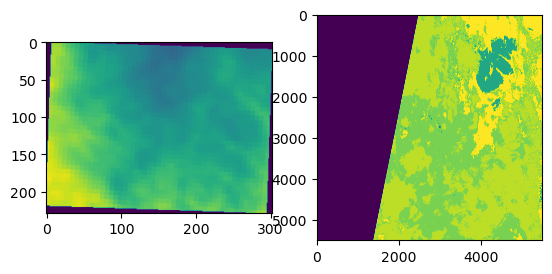

In [4]:
image = rasterio.open(join(img_path,img_list[3]+".tiff"))
print(image.crs)
scl = rasterio.open(join(scal_path,img_list[3]+".jp2"))
print(scl.crs)
shapes32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo4Shape, precision=6)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image.read(1))
axarr[1].imshow(scl.read(1))
outImage, outImageTransf = rasterio.mask.mask(image, campo4Shape, crop=True)
outScl, outSclTransf = rasterio.mask.mask(scl, shapes32632, crop=True)
plt.show()

# Read band file and scl masks

In [5]:

ShapedScl3 = []
ShapedScl4 = []
ShapedScl6 = []

ShapedImage3 = []
ShapedImage4 = []
ShapedImage6 = []

campo3Shape32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo3Shape, precision=6)
campo4Shape32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo4Shape, precision=6)
campo6Shape32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo6Shape, precision=6)

def cutScl(sclBig,shape,field):
    scl, sclTransform = rasterio.mask.mask(sclBig, shape, crop=True)
    scalefactor = [field.shape[1]/scl.shape[1],field.shape[2]/scl.shape[2]]
    outSclMeta = sclBig.meta
    outSclMeta.update({"driver": "GTiff",
                 "height": scl.shape[1],
                 "width": scl.shape[2],
                 "transform": outSclTransf})

    with MemoryFile() as memfile:
        with memfile.open(**outSclMeta) as dataset:  # Open as DatasetWriter
            dataset.write(scl)
        ramTemp = memfile.open()

    return ramTemp.read(
                out_shape=(
                    ramTemp.count, 
                    int(ramTemp.height*scalefactor[0]), 
                    int(ramTemp.width*scalefactor[1])
                    ),
                resampling=Resampling.nearest)[0]

for img in img_list:
    
    image = rasterio.open(join(img_path,img+".tiff"))
    scl = rasterio.open(join(scal_path,img+".jp2"))

    try:
        outImage3, outImageTransf3 = rasterio.mask.mask(image, campo3Shape, crop=True)
        outScl3 = cutScl(scl,campo3Shape32632,outImage3)
    except:
        print("shape3")
        print(img)
        print(scl.transform)

    try:
        outImage4, outImageTransf4 = rasterio.mask.mask(image, campo4Shape, crop=True)
        outScl4 = cutScl(scl,campo4Shape32632,outImage4)
    except:
        print("Shape4")
        print(img)
        print(scl.transform)

    try:
        outImage6, outImageTransf6 = rasterio.mask.mask(image, campo6Shape, crop=True)
        outScl6 = cutScl(scl,campo6Shape32632,outImage6)
    except:
        print("Shape 6")
        print(img)
        print(scl.transform)

    ShapedImage3.append(outImage3)
    ShapedScl3.append(outScl3)

    ShapedImage4.append(outImage4)
    ShapedScl4.append(outScl4)

    ShapedImage6.append(outImage6)
    ShapedScl6.append(outScl6)
    

ShapedImage3 = np.array(ShapedImage3).astype("int32")
ShapedScl3 = np.array(ShapedScl3)

ShapedImage4 = np.array(ShapedImage4).astype("int32")
ShapedScl4 = np.array(ShapedScl4)

ShapedImage6 = np.array(ShapedImage6).astype("int32")
ShapedScl6 = np.array(ShapedScl6)


# Filter out the bad pixels using the mask

In [6]:
print(ShapedImage3.shape)
print(ShapedScl3.shape)
totalDays = ShapedImage3.shape[0]
totalBands = ShapedImage3.shape[1]
for i in range(0,totalDays):
    Mask3 = (ShapedScl3[i,:,:] == 4) | (ShapedScl3[i,:,:] == 5) | (ShapedScl3[i,:,:] == 6)
    Mask4 = (ShapedScl4[i,:,:] == 4) | (ShapedScl4[i,:,:] == 5) | (ShapedScl4[i,:,:] == 6)
    Mask6 = (ShapedScl6[i,:,:] == 4) | (ShapedScl6[i,:,:] == 5) | (ShapedScl6[i,:,:] == 6)
    for j in range(0,totalBands):
        ShapedImage3[i,j,:,:] = np.ma.masked_array(ShapedImage3[i,j,:,:],Mask3,fill_value=0)
        ShapedImage4[i,j,:,:] = np.ma.masked_array(ShapedImage4[i,j,:,:],Mask4,fill_value=0)
        ShapedImage6[i,j,:,:] = np.ma.masked_array(ShapedImage6[i,j,:,:],Mask6,fill_value=0)

# Andiamo a salvare il campo 3 per analisi rendimento
with open('campo3_bande.pickle', 'wb') as handle:
    pickle.dump(ShapedImage3, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('campo4_bande.pickle', 'wb') as handle:
    pickle.dump(ShapedImage4, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('campo6_bande.pickle', 'wb') as handle:
    pickle.dump(ShapedImage6, handle, protocol=pickle.HIGHEST_PROTOCOL)

(57, 12, 56, 72)
(57, 56, 72)


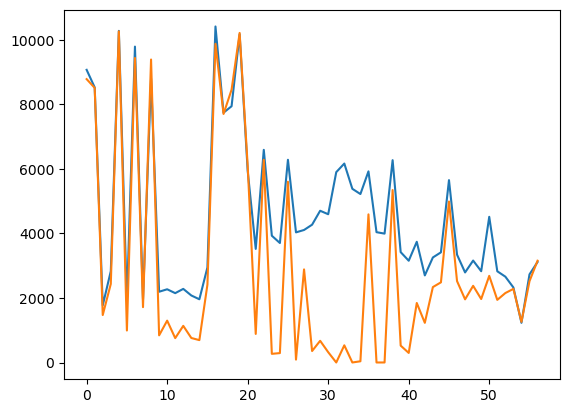

In [11]:
# solo per check

plt.plot(ShapedImage3[:,7,30,30])
plt.plot(ShapedImage3[:,3,30,30])

In [7]:

targetPath=r'C:\Users\pc\Desktop\Università\Computer vision and Deep Learning\Progetto\AgriVision2022\campo3.tiff'
outImageTransf3
outImageMeta = scl.meta
outImageMeta.update({"driver": "GTiff",
                 "height": ShapedImage3[56,3,:,:].shape[0],
                 "width": ShapedImage3[56,3,:,:].shape[1],
                 "transform": outImageTransf3,
                 "crs":image.crs})
with rasterio.open(targetPath, 'w', **outImageMeta) as dst:
        dst.write_band(1, ShapedImage3[56,3,:,:])

In [7]:
NDVI = np.divide(np.subtract(ShapedImage3[:,7,:,:],ShapedImage3[:,3,:,:]),np.add(ShapedImage3[:,7,:,:],ShapedImage3[:,3,:,:]))
np.nan_to_num(NDVI,0)
print(NDVI)
NDRE = np.divide(np.subtract(ShapedImage3[:,7,:,:],ShapedImage3[:,4,:,:]),np.add(ShapedImage3[:,7,:,:],ShapedImage3[:,4,:,:]))
np.nan_to_num(NDRE,0)
print(NDRE)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0. 0. 0

C:\Users\pc\AppData\Local\Temp\ipykernel_16200\2386686842.py:1: RuntimeWarning: invalid value encountered in true_divide
  NDVI = np.divide(np.subtract(ShapedImage3[:,7,:,:],ShapedImage3[:,3,:,:]),np.add(ShapedImage3[:,7,:,:],ShapedImage3[:,3,:,:]))
C:\Users\pc\AppData\Local\Temp\ipykernel_16200\2386686842.py:4: RuntimeWarning: invalid value encountered in true_divide
  NDRE = np.divide(np.subtract(ShapedImage3[:,7,:,:],ShapedImage3[:,4,:,:]),np.add(ShapedImage3[:,7,:,:],ShapedImage3[:,4,:,:]))


# Riportiamo le curve dei pixel

(57, 56, 72)


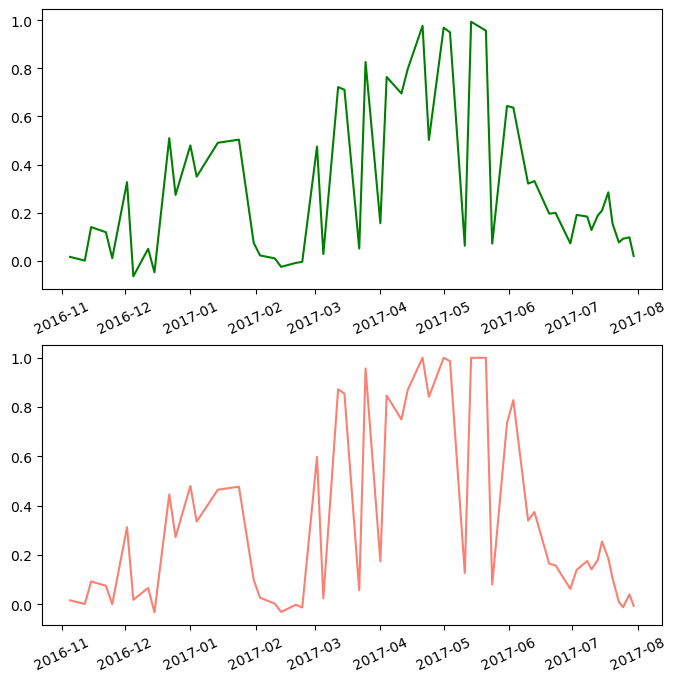

In [8]:
date = []
for a in img_list:
    date.append(datetime.strptime(a,"%Y-%m-%d"))

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
plt.sca(axs[0])
plt.xticks(rotation=25) # Questo mi serve solo per ruotare le label del tempo
'''for a in range(NDVI.shape[0]):
    for b in range(NDVI.shape[1]):
        axs[0].plot(date,NDVI[a,b,:])'''

print(NDVI.shape)
axs[0].plot(date,NDVI[:,13,43],color="green")

'''mean_value = []
for a in range(NDVI.shape[2]):
    mean_value.append(np.average(NDVI[:,:,a]))'''

axs[1].plot(date,NDVI[:,30,30],color="salmon")
plt.sca(axs[1])
plt.xticks(rotation=25)
plt.show()

# Utilizzo della funzione di smoooting per pulire la serie temporale 

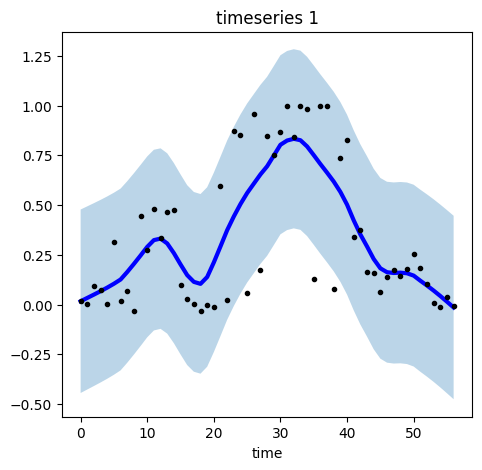

In [10]:
NDVIfilter = NDVI[:,30,30]
#filter = NDVI[:,30,30]>=1
#NDVIfilter = NDVIfilter[filter]

# operate smoothing
smoother = LowessSmoother(smooth_fraction=0.2, iterations=1)
smoother.smooth(NDVIfilter)

# generate intervals
low, up = smoother.get_intervals('prediction_interval')

# plot the smoothed timeseries with intervals
plt.figure(figsize=(18,5))

for i in range(1):
    
    plt.subplot(1,3,i+1)
    plt.plot(smoother.smooth_data[i], linewidth=3, color='blue')
    plt.plot(smoother.data[i], '.k')
    plt.title(f"timeseries {i+1}"); plt.xlabel('time')

    plt.fill_between(range(len(smoother.data[i])), low[i], up[i], alpha=0.3)

[ 1.61290323e-02  9.38967136e-04  9.24784217e-02  7.51708428e-02
  7.78816199e-04  3.12543313e-01  1.83028286e-02  6.63764962e-02
 -3.25417766e-02  4.45322793e-01  2.72421525e-01  4.79697178e-01
  3.35283792e-01  4.64411557e-01  4.77015825e-01  9.92537313e-02
  2.64091447e-02  2.58933195e-03 -3.12195122e-02 -1.96155355e-03
 -1.29525075e-02  5.98003630e-01  2.39204722e-02  8.71874256e-01
  8.53853854e-01  5.72005384e-02  9.56353055e-01  1.74721190e-01
  8.46153846e-01  7.49674540e-01  8.69812856e-01  9.99661132e-01
  8.40895522e-01  9.99628598e-01  9.85551331e-01  1.26747171e-01
  9.99505073e-01  9.99499499e-01  7.97039077e-02  7.34414597e-01
  8.27925840e-01  3.39538214e-01  3.74045802e-01  1.64104398e-01
  1.57627119e-01  6.22944658e-02  1.39594341e-01  1.75578947e-01
  1.41412317e-01  1.79658191e-01  2.54096084e-01  1.85744235e-01
  1.05525550e-01  9.54861111e-03 -1.20481928e-02  3.99695470e-02
 -6.37958533e-03]
[datetime.datetime(2016, 11, 5, 0, 0), datetime.datetime(2016, 11, 12, 0

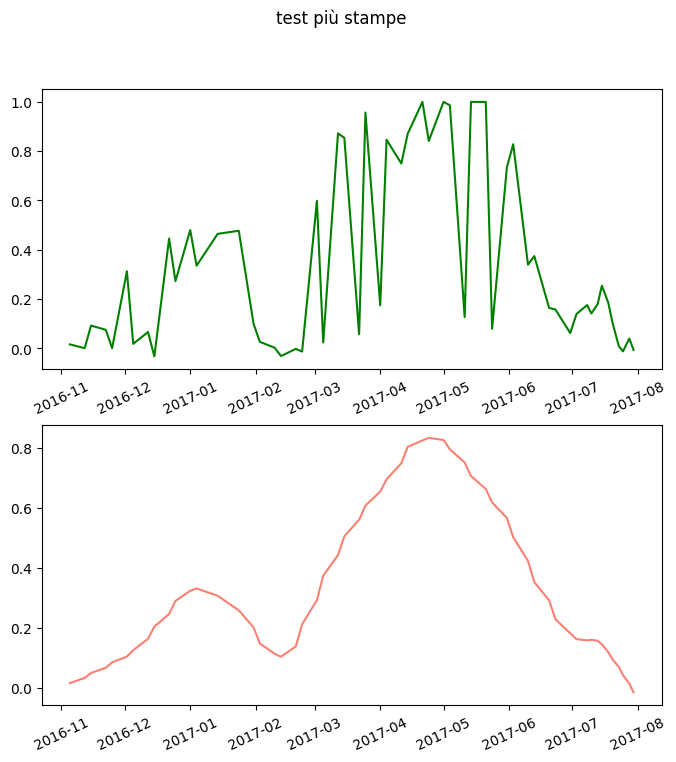

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
fig.suptitle('test più stampe')
plt.sca(axs[0])
plt.xticks(rotation=25) # Questo mi serve solo per ruotare le label del tempo
#filter = NDVI[:,30,30]>=1
#print(filter)
NDVIfilter = NDVI[:,30,30]
#NDVIfilter = NDVIfilter[filter]
#np.ma.masked_array(NDVI[:,30,30],filter)
print(NDVIfilter)
print(date)
axs[0].plot(date,NDVIfilter,color="green")

axs[1].plot(date,smoother.smooth_data[0],color="salmon")
plt.sca(axs[1])
plt.xticks(rotation=25)
plt.show()

# Rappresentazione delle varie curve con boxplot

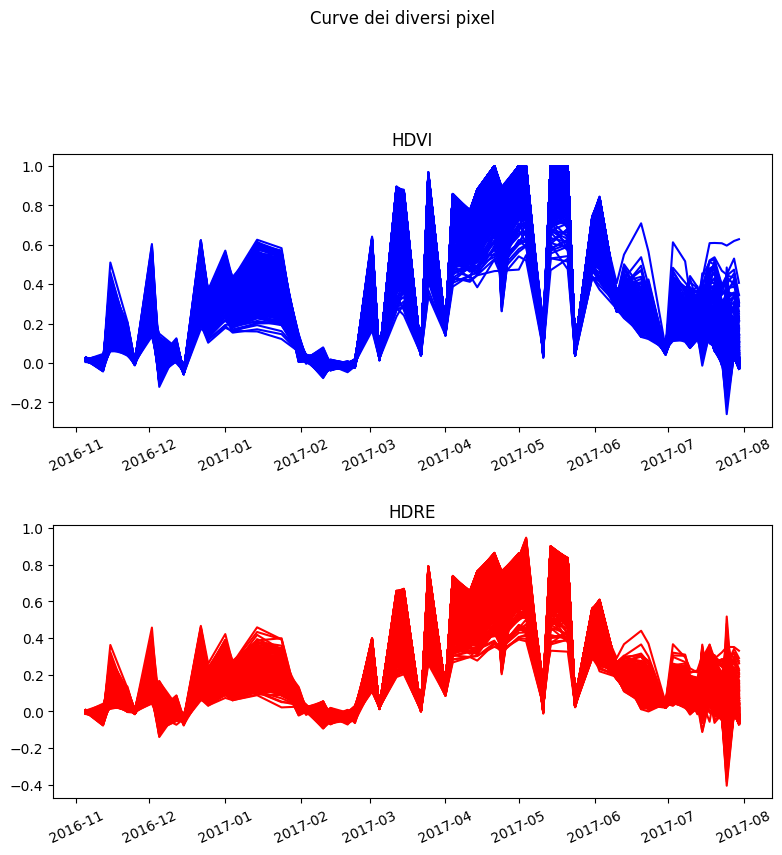

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9, 9))
fig.suptitle('Curve dei diversi pixel')
fig.tight_layout(pad=5.0)
plt.sca(axs[0])
plt.title('HDVI')
plt.xticks(rotation=25) # Questo mi serve solo per ruotare le label del tempo
validePixelNDVI = []
validePixelNDRE = []
for a in range(NDVI.shape[1]):
    for b in range(NDVI.shape[2]):
        if(np.sum(NDVI[:,a,b] != 0)):
            validePixelNDVI.append(NDVI[:,a,b])
            validePixelNDRE.append(NDRE[:,a,b])
        #axs.plot(date,NDVI[:,a,b],color='blue')

for a in range(len(validePixelNDVI)):
    axs[0].plot(date,validePixelNDVI[a],color='blue')

for a in range(len(validePixelNDRE)):
    axs[1].plot(date,validePixelNDRE[a],color='red')

plt.sca(axs[1])
plt.title('HDRE')
plt.xticks(rotation=25)
plt.show()

# Inserimento BoxPlot  NDVI

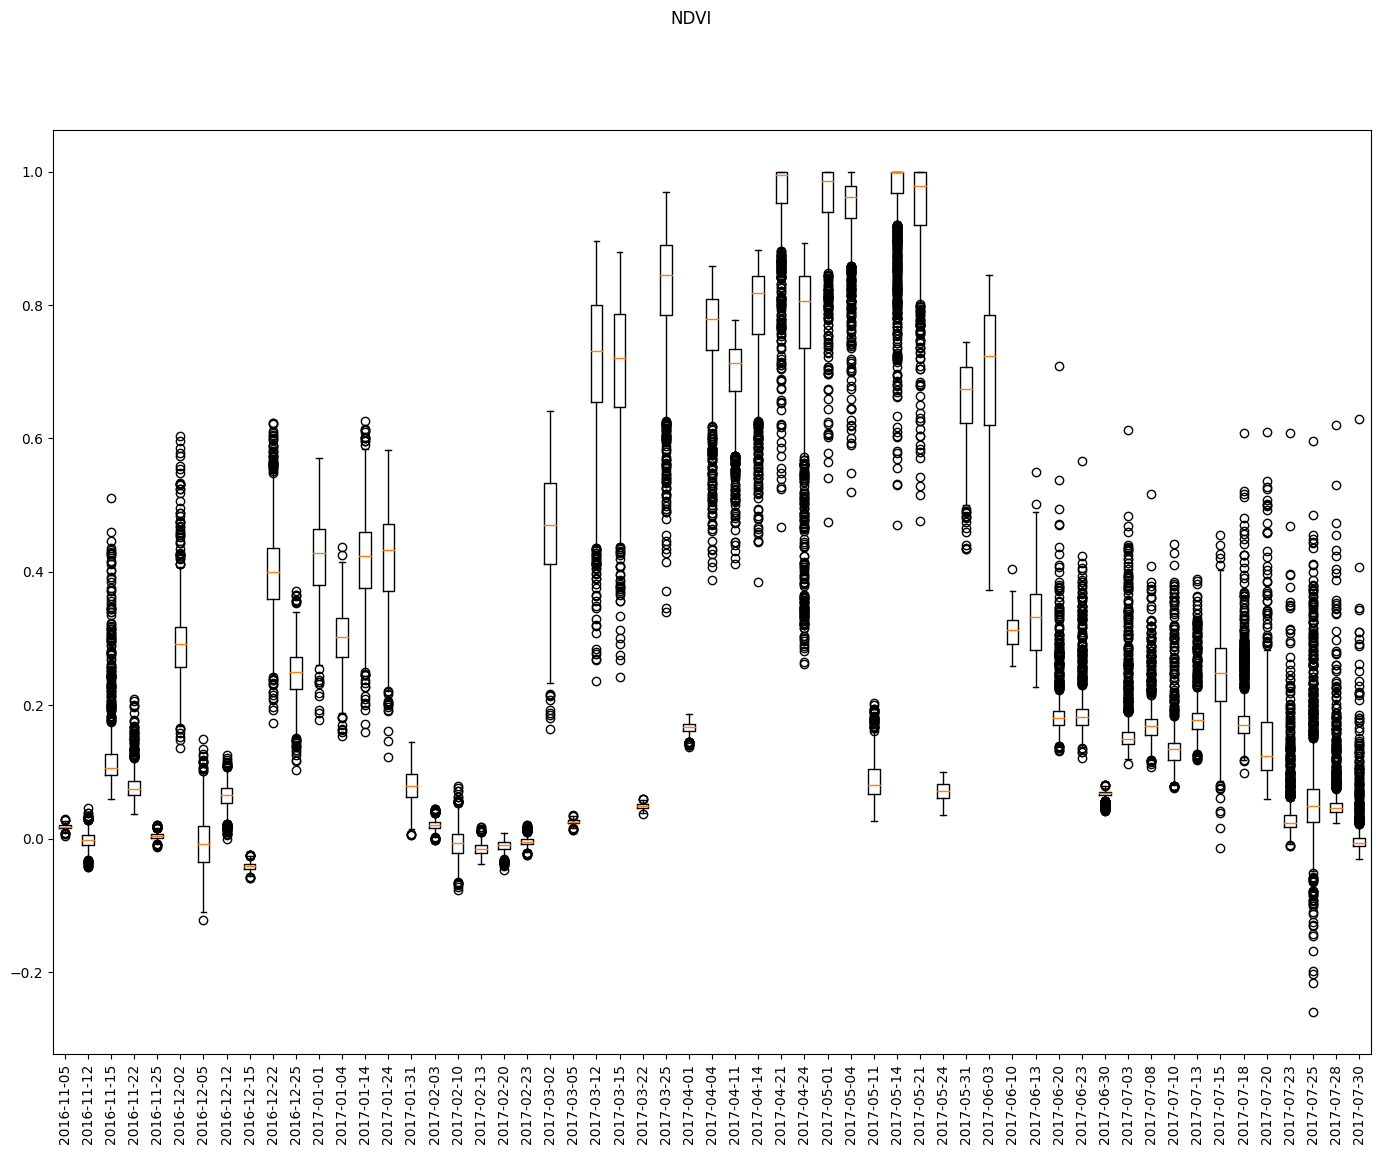

In [13]:
box_data = {}

for a in range(NDVI.shape[0]):
    filterBox = NDVI[a,:,:] != 0
    box = NDVI[a,:,:]
    box = box[filterBox]
    box_data[img_list[a]] = box



fig, axes = plt.subplots(figsize=(17, 12))
fig.suptitle('NDVI')

bplot1 = axes.boxplot(box_data.values(),labels=img_list)

plt.sca(axes)
plt.xticks(rotation=90)
plt.show()
plt.close('all')

    

# Crezione del BoxPlot per NDRE

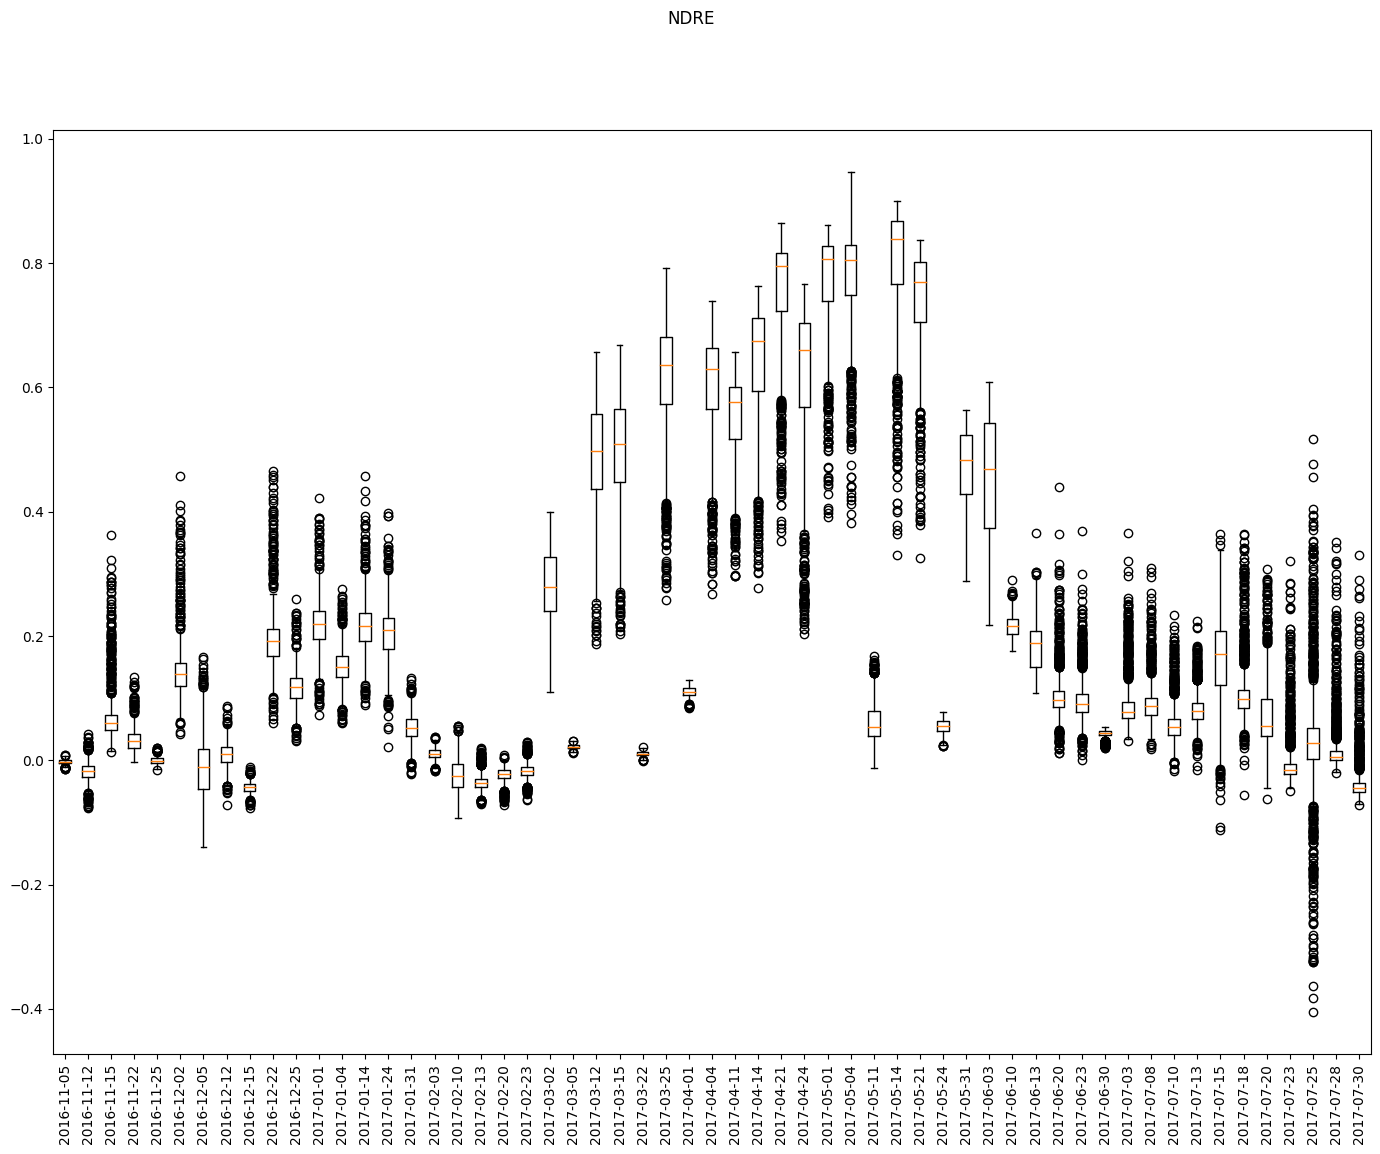

In [14]:
box_data2 = {}

for a in range(NDRE.shape[0]):
    filterBox = NDRE[a,:,:] != 0
    box = NDRE[a,:,:]
    box = box[filterBox]
    box_data2[img_list[a]] = box



fig, axes = plt.subplots(figsize=(17, 12))
fig.suptitle('NDRE')

bplot1 = axes.boxplot(box_data2.values(),labels=img_list)

plt.sca(axes)
plt.xticks(rotation=90)
plt.show()
plt.close('all')

# Test addestramento NeuralProphet su un pixel con smooth

In [15]:
import pandas as pd
from neuralprophet import NeuralProphet
from matplotlib import pyplot as plt
import pickle

# Costruisco il dataset

In [16]:
d = {'ds': date, 'y': NDVIfilter}
data = pd.DataFrame(data=d)
data.head(56)

,ds,y
0,2016-11-05,0.016129
1,2016-11-12,0.000939
2,2016-11-15,0.092478
3,2016-11-22,0.075171
4,2016-11-25,0.000779
5,2016-12-02,0.312543
6,2016-12-05,0.018303
7,2016-12-12,0.066376
8,2016-12-15,-0.032542
9,2016-12-22,0.445323


# Addestramento del modello

In [17]:
m = NeuralProphet()

In [18]:
model = m.fit(data, freq='D', epochs=500)

INFO - (NP.df_utils._infer_frequency) - Major frequency 3D corresponds to 45.614% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (4) is too small than the required number for the learning rate finder (204). The results might not be optimal.


Finding best initial lr:   0%|          | 0/204 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

# Previsioni

In [19]:
future = m.make_future_dataframe(data, periods=60)
forecast = m.predict(future)
forecast.head(100)

INFO - (NP.df_utils._infer_frequency) - Major frequency 3D corresponds to 45.614% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 4it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_weekly
0,2017-07-31,None,-0.120007,-0.054431,-0.065577
1,2017-08-01,None,-0.051716,-0.063907,0.012190
2,2017-08-02,None,-0.152945,-0.073382,-0.079563
3,2017-08-03,None,-0.125754,-0.082858,-0.042896
4,2017-08-04,None,-0.123665,-0.092334,-0.031332
5,2017-08-05,None,-0.037400,-0.101810,0.064410
6,2017-08-06,None,0.031481,-0.111285,0.142767
7,2017-08-07,None,-0.186338,-0.120761,-0.065577
8,2017-08-08,None,-0.118047,-0.130237,0.012190
9,2017-08-09,None,-0.219275,-0.139713,-0.079563


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


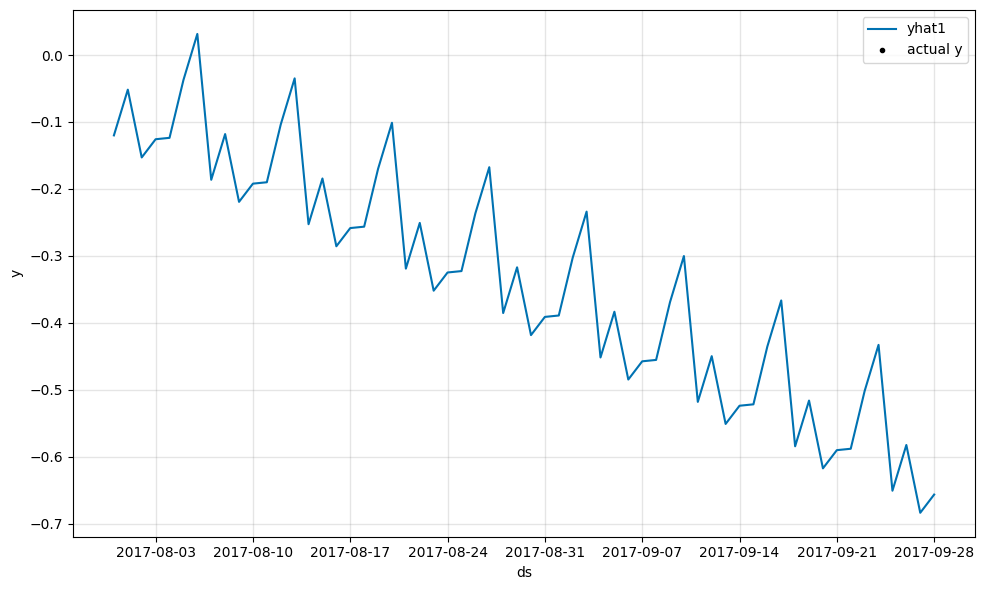

In [20]:
plot1 = m.plot(forecast)

# Taglio delle curve

In [21]:
img_list.index('2017-02-13')
img_list.index('2017-07-15')
NDVI_cut = NDVI[18:50,:,:]
NDRE_cut = NDRE[18:50,:,:]
print(NDVI_cut.shape)
print(NDRE_cut.shape)


(32, 56, 72)
(32, 56, 72)


# Esempio uso di FPCA

In [22]:
import matplotlib.pyplot as plt

import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)

dataset = skfda.datasets.fetch_growth()
#print(dataset)
fd = dataset['data']
print(type(fd))
y = dataset['target']
#fd.plot()
#print(y)

'''fpca_discretized = FPCA(n_components=1)
fpca_discretized.fit(fd)
fpca_discretized.components_.plot()'''


<class 'skfda.representation.grid.FDataGrid'>


'fpca_discretized = FPCA(n_components=1)\nfpca_discretized.fit(fd)\nfpca_discretized.components_.plot()'

# Nuovo BoxPlot

[43, 50, 53, 60, 63, 70, 73, 80, 83, 90, 93, 100, 103, 110, 113, 120, 123, 130, 133, 140, 143, 150, 153, 160, 163, 170, 173, 180, 183, 188, 190, 193]


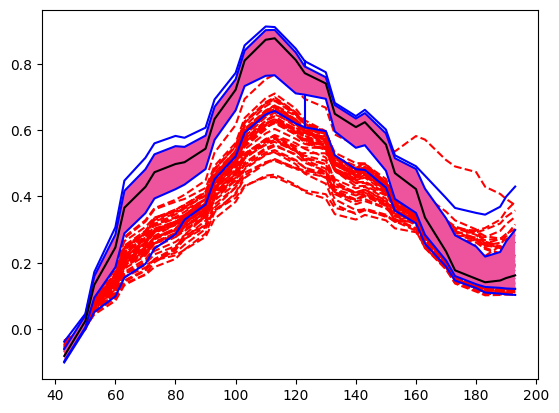

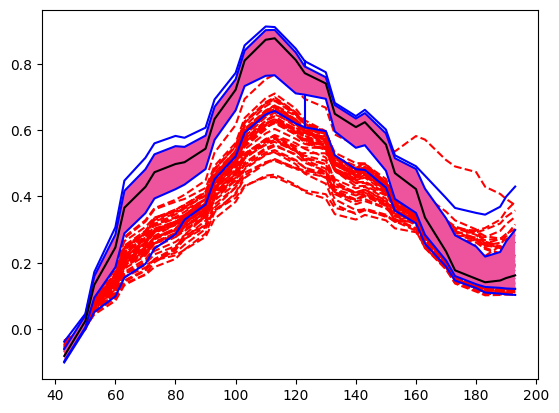

In [23]:
import skfda
import matplotlib.pyplot as plt
from skfda import datasets
from skfda.exploratory.depth import ModifiedBandDepth, IntegratedDepth
from skfda.exploratory.visualization import Boxplot

smoother = LowessSmoother(smooth_fraction=0.2, iterations=1) # Mi serve per smussare le curve

days = []
zeroDay = datetime.strptime("2017-01-01","%Y-%m-%d")
date_cut = date[18:50]
for a in date_cut:
    days.append((a-zeroDay).days)

print(days)

grid_points = days  # Grid points of the curves
data_matrixNDVI = []
for a in range(NDVI_cut.shape[1]):
    for b in range(NDVI_cut.shape[2]):
        if(np.sum(NDVI[:,a,b] != 0)):
            '''smoother.smooth(NDVI_cut[:,a,b]).smooth_data
            print(smoother.smooth(NDVI_cut[:,a,b]).smooth_data[0])'''
            data_matrixNDVI.append(smoother.smooth(NDVI_cut[:,a,b]).smooth_data[0])


fd_NDVI = skfda.FDataGrid(
    data_matrix=data_matrixNDVI,
    grid_points=grid_points,
)

fdBoxplot = Boxplot(fd_NDVI)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()
#fd.plot()


# Nuovo Box plot NDRE

[43, 50, 53, 60, 63, 70, 73, 80, 83, 90, 93, 100, 103, 110, 113, 120, 123, 130, 133, 140, 143, 150, 153, 160, 163, 170, 173, 180, 183, 188, 190, 193]


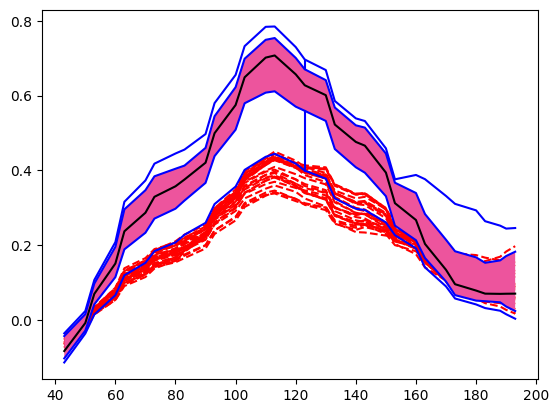

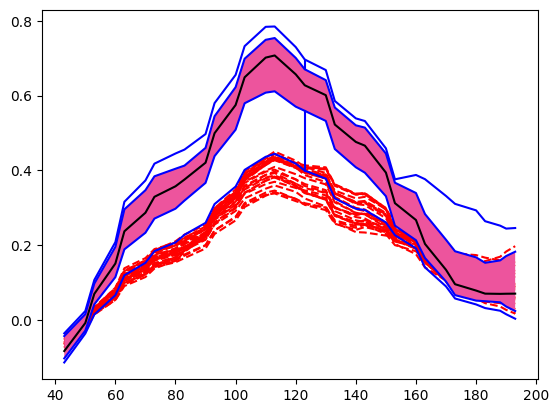

In [24]:
smoother = LowessSmoother(smooth_fraction=0.2, iterations=1) # Mi serve per smussare le curve

days = []
date_cut = date[18:50]
for a in date_cut:
    days.append((a-zeroDay).days)

print(days)

grid_points = days  # Grid points of the curves
data_matrixNDRE = []
for a in range(NDRE_cut.shape[1]):
    for b in range(NDRE_cut.shape[2]):
        if(np.sum(NDVI[:,a,b] != 0)):
            data_matrixNDRE.append(smoother.smooth(NDRE_cut[:,a,b]).smooth_data[0])


fd_NDRE = skfda.FDataGrid(
    data_matrix=data_matrixNDRE,
    grid_points=grid_points,
)

fdBoxplot = Boxplot(fd_NDRE)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()
#fd.plot()

# Applicazione della FPCA

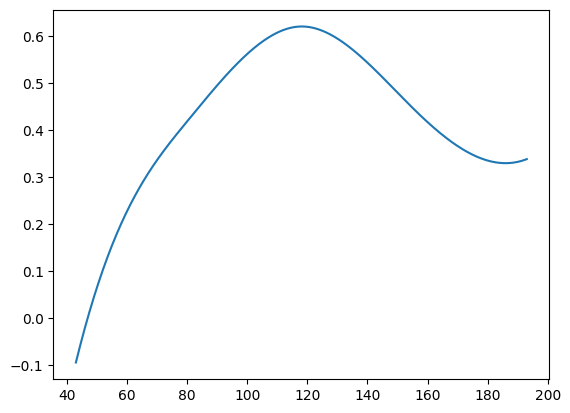

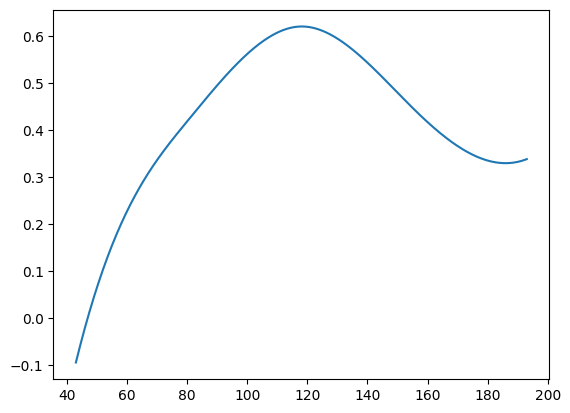

In [25]:
import matplotlib.pyplot as plt

import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)

fpca_discretized = FPCA(n_components=2)
basis = skfda.representation.basis.BSplineBasis(n_basis=7)
fpca_discretized.fit(fd_NDVI.to_basis(basis=basis))
#fpca_discretized.components_.plot()

somma = fpca_discretized.components_[0]+fpca_discretized.components_[1]+fpca_discretized.mean_
somma.plot()

# Data augmentation

In [29]:
newSeriesNDVI = []
newSeriesNDRE = []
rangeNewGridPoint = range(grid_points[0],grid_points[len(grid_points)-1])

for b in range(len(data_matrixNDVI)):
    newSeriesNDVI.append([])
    newSeriesNDRE.append([])

for a in rangeNewGridPoint:
    try:
        i = grid_points.index(a)
        for c in range(len(data_matrixNDVI)):
            newSeriesNDVI[c].append(data_matrixNDVI[c][i])
            newSeriesNDRE[c].append(data_matrixNDRE[c][i])
    except:
        for c in range(len(data_matrixNDVI)):
            newSeriesNDVI[c].append(somma(a)[0][0][0])
            #newSeriesNDRE[c].append(somma[]) #da finire non abbiamo somma NDRE







# Plot della nuova serie temporale

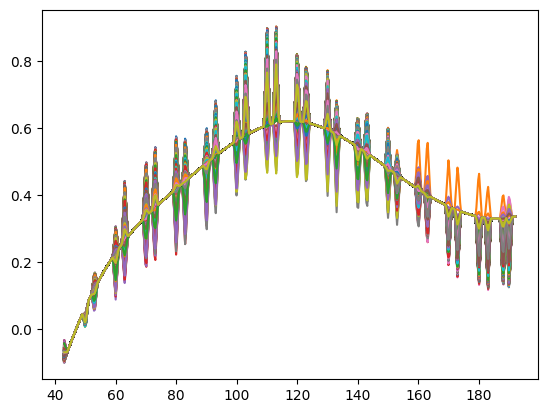

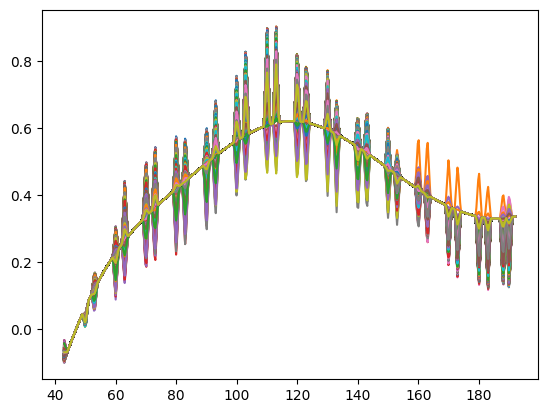

In [30]:
fd_NDVI_New = skfda.FDataGrid(

    data_matrix=newSeriesNDVI,

    grid_points=rangeNewGridPoint,

)

fd_NDVI_New.plot()

# Andiamo a fare uno smoothing della fpca

0.6191500910567884


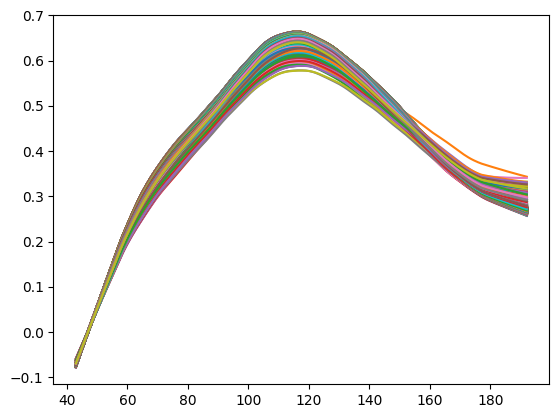

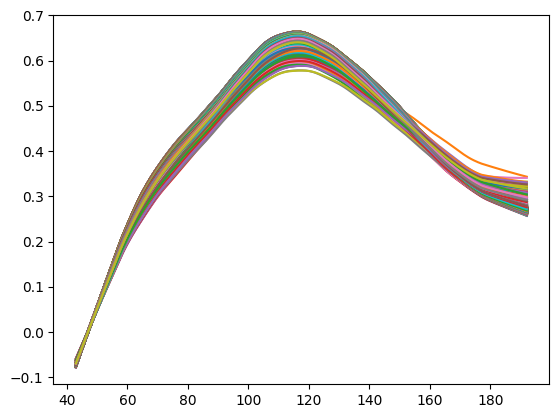

In [32]:
NewMatrixNDVI = []
print(somma(120)[0][0][0])
for b in range(len(data_matrixNDVI)):
    NewMatrixNDVI.append([])
    NewMatrixNDVI[b] = smoother.smooth(newSeriesNDVI[b]).smooth_data[0]
fd_NDVI_New = skfda.FDataGrid(
    data_matrix=NewMatrixNDVI,
    grid_points=rangeNewGridPoint,
)
fd_NDVI_New.plot()

# Andiamo a salvare le serie come pickle

In [33]:
with open('hdvi.pickle', 'wb') as handle:
    pickle.dump(fd_NDVI_New, handle, protocol=pickle.HIGHEST_PROTOCOL)